Import des librairies

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pythermalcomfort import two_nodes
from SALib.sample import sobol
from SALib.analyze import sobol as analyse_sobol
from SALib.plotting.bar import plot as barplot


In [2]:
def model4sa(tdb,
                tr,
                v,
                rh,
                met,
                clo,
                standard="ASHRAE", limit_inputs=False, round=False):
    
    pythermal=two_nodes(tdb=tdb,
                        tr=tr,
                        v=v,
                        rh=rh,
                        met=met,
                        clo=clo,
                        standard="ASHRAE", limit_inputs=False, round=False)
    
    pts = 0.25 * pythermal['_set'] - 6.03
    es=1.33
    l=0.195
    tsv_se = es * pts
    tsv_sa = pts/(1+l*pts)
    
    return {"_set": pythermal['_set'],
                    "et":pythermal['et'],
                    "t_core" : pythermal['t_core'],
                    "t_skin" : pythermal['t_skin'],
                    "pmv_gagge" : pythermal['pmv_gagge'],
                    "pmv_set" : pythermal['pmv_set'],
                    'w' : pythermal['w'],
                    'w_max' : pythermal['w_max'],
                    "disc" : pythermal['disc'],
                    "t_sens" : pythermal['t_sens'],
                    'pts' : pts,
                    'tsv_se':tsv_se,
                    'tsv_sa':tsv_sa}

In [3]:
model_output_names="_set"
                    # "et",
                    # "t_core",
                    # "t_skin",
                    # "pmv_gagge",
                    # "pmv_set",
                    # 'w',
                    # 'w_max',
                    # "disc",
                    # "t_sens",
                    # 'pts',
                    # 'tsv_se',
                    # 'tsv_sa'
                    
                    

In [4]:
# Define number of sample for SA, need to be determined after a Si (S1) convergence study
samples=10000
# Define input variable ranges based on possible model inputs
lower_v = 0.01 
upper_v = 2.2
# lower_met = 0.65
# upper_met = 1.26
lower_clo = 0.29
upper_clo = 0.79
lower_tdb = 25.4
upper_tdb = 32.1
lower_tr = 23.1
upper_tr = 31.2
lower_rh = 60
upper_rh = 90

In [5]:
# Define SA problem (SALIB package)
problem = {
    'num_vars': 5, # number of variable inputs
    'names': [ 'tdb','tr','rh','v','clo'], # input names in correct order
    'bounds': [
        [lower_tdb, upper_tdb],
        [lower_tr, upper_tr],
        [lower_rh, upper_rh],
        [lower_v, upper_v],
        [lower_clo, upper_clo]
            ],
    'dist' : ['unif',
              'unif',
              'unif',
              'unif',
              'unif']    
            
        }

In [6]:
# Generate the parameter samples using SALIB RBDfast recommanded method (Latin Hypercube sampling)
sampling = sobol.sample(problem, samples)
# Evaluate model
Y = [model4sa(tdb=params[0],
                    tr=params[1],
                    rh=params[2],
                    v=params[3],
                    met=1.1,
                    clo=params[4],
                    standard="ASHRAE", limit_inputs=False, round=False)[model_output_names] for params in sampling
                    ]

c:\_GIT_HUB_PIMENTLAB\simurex-atelier-sa\.venv\lib\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [7]:
pd.DataFrame(Y)

,0
0,24.379971
1,25.731964
2,22.522740
3,24.383896
4,26.914536
...,...
119995,26.364077
119996,24.684891
119997,24.613639
119998,26.200325


In [8]:
Si = analyse_sobol.analyze(problem,  np.asarray(Y), calc_second_order=True,print_to_console=False)
total, first, second = Si.to_df()

           ST   ST_conf
tdb  0.423625  0.013191
tr   0.090100  0.002829
rh   0.059261  0.002494
v    0.221159  0.007569
clo  0.228244  0.006854


<Axes: >

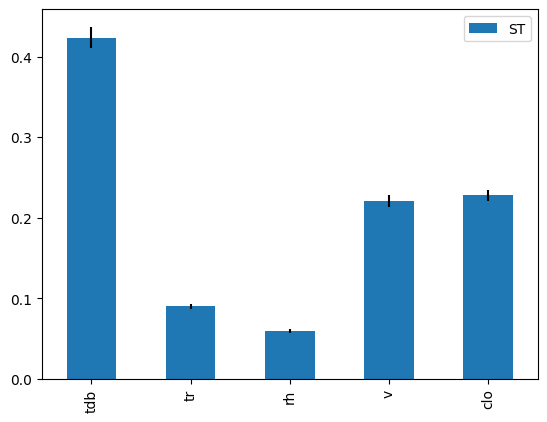

In [9]:
print(total)
barplot(total)


           S1   S1_conf
tdb  0.410322  0.016279
tr   0.085176  0.008570
rh   0.045549  0.007165
v    0.212725  0.013773
clo  0.224610  0.011778


<Axes: >

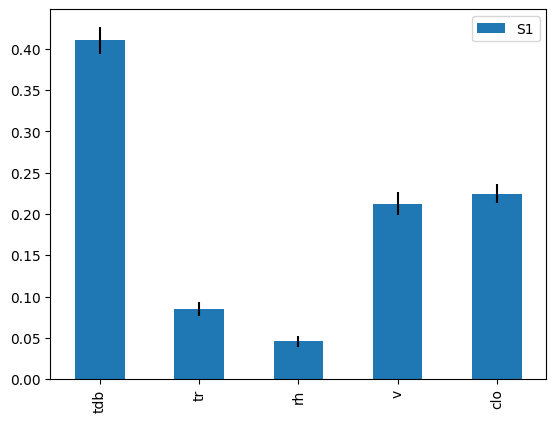

In [10]:
print(first)
barplot(first)

                  S2   S2_conf
(tdb, tr)   0.000084  0.022314
(tdb, rh)   0.011331  0.022823
(tdb, v)    0.001482  0.022622
(tdb, clo)  0.000367  0.024660
(tr, rh)   -0.000265  0.011029
(tr, v)     0.003738  0.012553
(tr, clo)  -0.000172  0.011725
(rh, v)     0.000984  0.012457
(rh, clo)   0.001048  0.011384
(v, clo)    0.001136  0.020380


<Axes: >

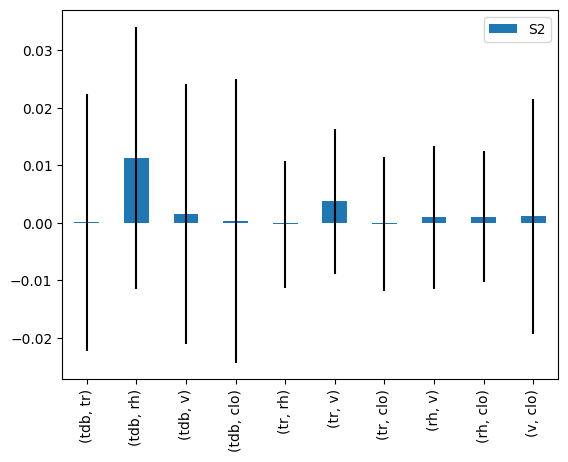

In [11]:
print(second)
barplot(second)